## Importando librerías

In [386]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Carga de dataset

In [387]:
dataset = pd.read_csv('forestfires.csv').drop(columns=['month', 'day'])
Xpd = dataset.iloc[:, :-1]
X = Xpd.to_numpy().astype(np.float32)
yreal = dataset.iloc[:, -1].to_numpy().astype(np.float32)
# yreal = np.log(yreal + 1)

## Interpretación Previa

#### Correlación de las variables

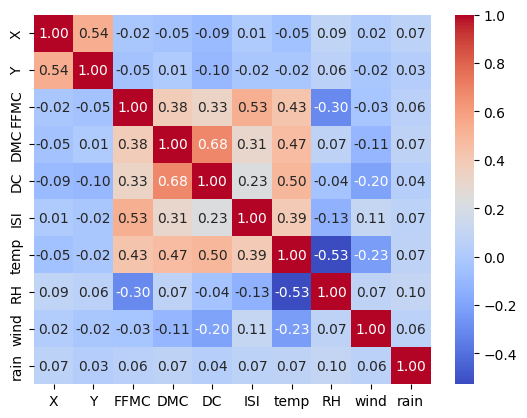

In [388]:
sns.heatmap(np.corrcoef(X.T), annot=True, cmap='coolwarm', fmt=".2f", 
                        xticklabels=dataset.columns[:-1], yticklabels=dataset.columns[:-1])
plt.show()

In [389]:
# Xsel = Xpd[['temp', 'RH', 'wind', 'rain']]
# sns.boxplot(data=pd.DataFrame(Xsel, columns=Xsel.columns[:-1]))
# # eliminando valores atípicos en Xpd
# Q1 = Xsel.quantile(0.25)
# Q3 = Xsel.quantile(0.75)
# IQR = Q3 - Q1
# Xsel = Xsel[~((Xsel < (Q1 - 1.5 * IQR)) | (Xsel > (Q3 + 1.5 * IQR))).any(axis=1)]

## Regresión multivariable

In [390]:
class NoLinearRegression:
    def __init__(self, X_train, Y_train, alpha, _lambda):
        self._lambda = _lambda
        self.X_train: np.ndarray = X_train
        self.Y_train: np.ndarray = Y_train
        self.W = [1] + list(np.random.rand(X_train.shape[1]))
        print(self.X_train.shape)
        print(len(self.W))
        self.alpha = alpha

    def H(self, X, W):
        return np.dot(X, W)
    
    def Loss(self):
        n = len(self.Y_train)
        return (1/(2*n)) * (np.linalg.norm(self.Y_train - self.H(self.X_train, self.W)) ** 2)
    
    def Lasso(self):
        return self.Loss() + (self._lambda * np.sum(np.abs(self.W)))
    
    def Ridge(self):
        return self.Loss() + (self._lambda * np.linalg.norm(self.W) ** 2)
    
    def Derivative(self):
        n = len(self.Y_train)
        return (1/n) * np.dot(self.X_train.T, self.Y_train - self.H(self.X_train, self.W))
    
    def LassoDerivative(self):
        return self.Derivative() + self._lambda * np.sum(np.abs(self.W))
    
    def RidgeDerivative(self):
        return self.Derivative() + 2 * (self._lambda * np.linalg.norm(self.W) ** 2)
 
    def LassoUpdate(self):
        self.W = self.W - self.alpha * self.LassoDerivative()

    def RidgeUpdate(self):
        self.W = self.W - self.alpha * self.RidgeDerivative()

    def reset(self):
        self.W = np.random.rand(self.X_train.shape[1])

    def LassoTrain(self, epochs):
        L = self.Lasso()
        L_reg = []
        for _ in range(epochs):
            self.LassoUpdate()
            self.Y_train = self.H(self.X_train, self.W)
            L = self.Lasso()
            L_reg.append(L)
        return L, L_reg

    def RidgeTrain(self, epochs):
        L = self.Ridge()
        L_reg = []
        for _ in range(epochs):
            self.RidgeUpdate()
            self.Y_train = self.H(self.X_train, self.W)
            L = self.Ridge()
            L_reg.append(L)
        return L, L_reg

## Training y Testing

In [391]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, yreal, test_size = 0.3, random_state = 0)
X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

In [392]:
epochs = 1000
lineal = NoLinearRegression(X_train, y_train, 0.001, 0.01)
lineal.reset()

(361, 11)
12


#### Con regul. Lasso

<AxesSubplot: >

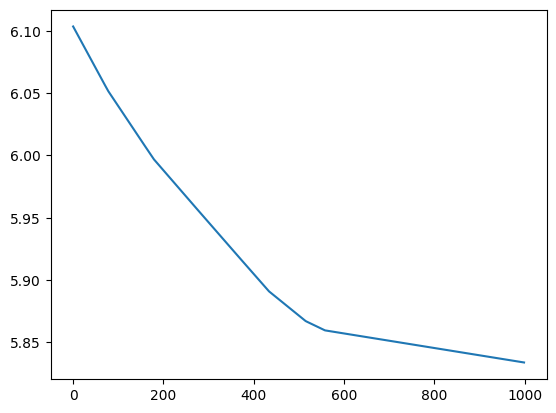

In [393]:
L, L_reg = lineal.LassoTrain(epochs)
sns.lineplot(x=range(epochs), y=L_reg)